In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install scrapy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 271 kB 7.5 MB/s 
     |████████████████████████████████| 261 kB 44.3 MB/s 
     |████████████████████████████████| 57 kB 4.3 MB/s 
     |████████████████████████████████| 93 kB 2.7 MB/s 
     |████████████████████████████████| 3.1 MB 45.5 MB/s 
     |████████████████████████████████| 4.0 MB 43.5 MB/s 
     |████████████████████████████████| 74 kB 3.0 MB/s 
  Created wheel for PyDispatcher: filename=PyDispatcher-2.0.6-py3-none-any.whl size=11959 sha256=acf9e09e0f1f91575d740819b00b4c9d5d126730b10ee49dcf321dc52ced2c41
  Stored in directory: /root/.cache/pip/wheels/dc/b9/4a/948b1176e084b9e3f85e4ffc3d08f817b1fdf0d973bbb94f81
Successfully built PyDispatcher


In [ ]:
%pwd

'/content'

In [ ]:
!scrapy startproject proyecto_imdb "/content/drive/MyDrive/PIA/EJEMPLO_SCRAPY"

Error: scrapy.cfg already exists in /content/drive/MyDrive/PIA/EJEMPLO_SCRAPY


In [ ]:
%cd "/content/drive/MyDrive/PIA/EJEMPLO_SCRAPY/proyecto_imdb"

/content/drive/MyDrive/PIA/EJEMPLO_SCRAPY/proyecto_imdb


In [ ]:
!scrapy genspider imdb https://www.imdb.com

In [ ]:
%cd "/content/drive/MyDrive/PIA/EJEMPLO_SCRAPY/proyecto_imdb/spiders"

/content/drive/MyDrive/PIA/EJEMPLO_SCRAPY/proyecto_imdb/spiders


In [ ]:
!scrapy crawl imdb -O imdb.json

In [ ]:
# !scrapy crawl imdb 2>&1 | tee crawl.log

In [ ]:
#!scrapy crawl imdb -O imdb.json

In [ ]:
%%writefile "/content/drive/MyDrive/imdb_v14.py"
# versión 14

# Autor: Adonais Ferández Martín

# Fecha última modificación : 01/12/2022

# Saca la información de la lista de películas del género comedia en IMDB
# Falta entrar en cada enlace y obtener la información sobre el número
# de críticas y reseñas.

from ast import YieldFrom
import scrapy
from scrapy.exceptions import CloseSpider


class Ej124112022V1Spider(scrapy.Spider):
    name = 'imdb'
    initial_url = 'https://www.imdb.com'
    start_urls = ['https://www.imdb.com/search/title/?genres=comedy&start=1&explore=title_type,genres&ref_=adv_nxt']
    page_number = 1
    outputs = 0
    MAX_PAGE_NUMBER = 3
  
    def parse(self, response):        
        self.logger.info('****************************************************')
        self.logger.info('Hola, estamos en: %s', response.url)
        # --------------------------------------------------------------
        
        # Condición de finalización del programa: nos detenemos cuando
        # se hayan visitado el número de páginas (lista de película del
        # género comedia en imdb.com) que hayamos determinado
        if self.page_number > self.MAX_PAGE_NUMBER: 
            raise CloseSpider('Spider closed')
        
        # --------------------------------------------------------------      
        
        movies = response.css('div.lister-item-content')
        self.outputs += len(movies)
        print("\n-----------------------------------------------")        
        print(f"Num. total de películas hasta ahora: {self.outputs}")
        print("-----------------------------------------------\n")
        # --------------------------------------------------------------
        # Metemos en un diccionario la información de cada película 
        # que nos interese
        for i in movies:
            d = {
            "id":"",
            "title":"",
            "stars":"",
            "votes":"",
            "ru":"",
            "rc":"",
            "link":""
            }
            d["id"] =  i.css('h3 > span::text').get()
            d["title"] =  i.css('h3 > a::text').get()
            d["stars"] =  i.css('div > div > strong::text').get()
            d["votes"] =  i.css('p.sort-num_votes-visible').xpath('./span[@name="nv"]/text()').get()
            href = i.css('h3 > a::attr(href)').get()
            link = self.initial_url + href
            d["link"] = link
            
            # Petición a la página de detalle. Pasamos nuestro diccionario
            # de datos de películas como parámetro
            yield scrapy.Request(url=link, callback=self.parse_detail, cb_kwargs={'d': d})
    
        # --------------------------------------------------------------
        # Incrementamos el contado de página visitadas
        self.page_number += 1
        
        # Obtenemos el enlace de la página siguiente que queremos visitar
        result = response.css('a.lister-page-next.next-page')
        href = result.css('a::attr("href")').get()
        next_page = self.initial_url + href      
        
        # Se utilizan técnicas recursivas para ir de una
        # página d <imdb> a otra. La condición de parada de
        # las llamadas recursivas está definida por la variable <next_page>
        # Si el valor de <next_page> es una cadena de texto vacía
        # entonces es que no hay más páginas que visitar.
        if (len(next_page) != 0):
            yield response.follow(next_page, callback=self.parse)


    # ==================================================================

    # Esta función ha scrapping de cada película de la lista del género comedia
    # y saca información de ella que luego se añadirá a la existente.
    # Además esta función devuelve el resultado final hacia la salida
    # predeterminada
    def parse_detail(self, response, d):

        # Buscamos las reseñas de los críticos y usuarios:
        # ru = reseñas de usuarios
        # rc = reseñas de críticos
        r1 = response.css('li:nth-child(1) > a > span > span')
        ru = r1.css('span::text').get()
        r2 = response.css('li:nth-child(2) > a > span > span')
        rc = r2.css('span::text').get()

        d["ru"] = ru
        d["rc"] = rc 
        
        # Devolvemos los resultados hacia la salida que hayamos determinado
        yield {
            "id"                : d["id"],
            "title"             : d["title"],
            "votes"             : d["votes"],
            "User reviews"      : d["ru"],
            "Critic reviews"    : d["rc"],
            "link"              : d["link"]
        }        
   


Writing /content/drive/MyDrive/imdb_v14.py


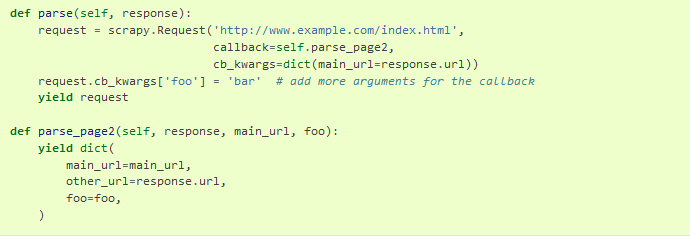

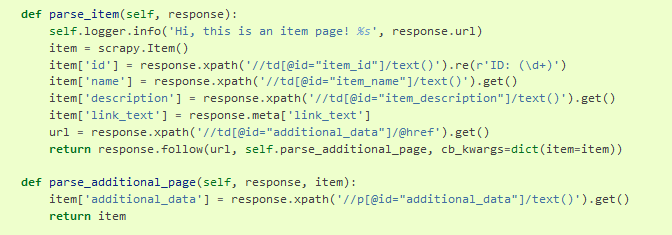

In [ ]:
# Almacén de comandos útiles
"""
--nolog
scrapy --help

# para volcar el log en un archivo
!scrapy crawl imdb_v3 2>&1 | tee crawl.log
"""

# Almacén de expresiones para el spider
"""
            #votes = i.css('p:nth-child(6) > span:nth-child(2) span::text').get()
            #votes = i.xpath('//p[@class="sort-num_votes-visible"]//span[@name="nv"]/data()').get()
            #votes = i.css('p > span').attrib('')
            #votes = i.xpath('//span[@name="nv"]/data()').get()
            #votes = response.xpath('[//span[@name="nv"]/text()').get()
            # votes = i.css('p > span').
            # stars = i.css('img').attrib['src']
            #//p[@class="sort-num_votes-visible"]
"""